In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:

df = pd.read_csv("global_inflation_data.csv")
df1 = df.melt(id_vars=["country_name", "indicator_name"], var_name="year", value_name="inflation_rate")
df1["year"] = df1["year"].astype(int)
df1["inflation_rate"] = df1.groupby("country_name")["inflation_rate"].transform(lambda x: x.interpolate(method="linear").bfill().ffill())
df1.drop(columns=['indicator_name'], inplace=True)


In [3]:

df1["inflation_rate"] = np.log1p(df1["inflation_rate"])
df1["prev_year"] = df1.groupby("country_name")["inflation_rate"].shift(1)
df1["prev_year"] = df1.groupby("country_name")["prev_year"].transform(lambda x: x.bfill().ffill())

df1["inflation_rate"].replace([np.inf, -np.inf], np.nan, inplace=True)
df1["inflation_rate"].fillna(method="bfill", inplace=True)
df1["prev_year"].replace([np.inf, -np.inf], np.nan, inplace=True)
df1["prev_year"].fillna(method="bfill", inplace=True)


In [4]:


X = df1[["country_name", "year", "prev_year"]]
y = df1["inflation_rate"]

X = pd.get_dummies(X, columns=["country_name"], drop_first=True)


In [5]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}


In [6]:


random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}


In [9]:

best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Optimized Mean Absolute Error: {mae}")
print(f"Optimized Root Mean Squared Error: {rmse}")

cv_score = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation Negative MSE: {cv_score.mean()}")


Optimized Mean Absolute Error: 0.41233391023868704
Optimized Root Mean Squared Error: 0.6503776207289955
Cross-Validation Negative MSE: -0.5104988641941987


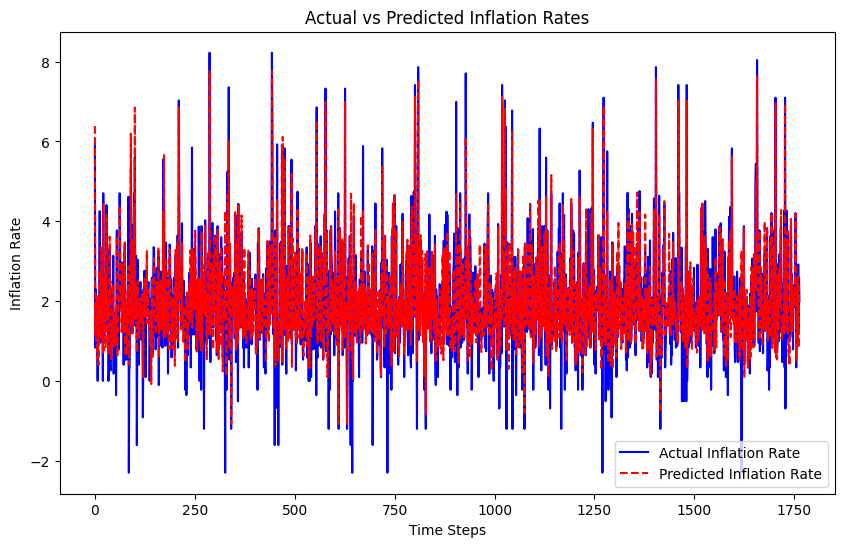

In [11]:





plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Inflation Rate', color='blue')
plt.plot(y_pred, label='Predicted Inflation Rate', color='red', linestyle='--')
plt.title("Actual vs Predicted Inflation Rates")
plt.xlabel("Time Steps")
plt.ylabel("Inflation Rate")
plt.legend()
plt.show()
